## Goal

In this mini project, you are provided with a synthetic dataset. The goals are:

* Detect data issues in the dataset
* Build a model that uses the existing information to predict responder `resp`, which is the return from one day's price to the next trading date's price for given stocks.
* Implement the function `predict_fn` which will evaluate your model's predictions based on test dataset, which is not provided.

Note that the evaluation of this mini project focuses on your **process** rather than **result**. Your notebook should reflect your thinking and working process, which we will carefully review. If you find lots of helpful insights from the dataset, even if they don't end up helping your model's performance, you still get credits for finding these. If you do things that follows the best practice, you still get credits no matter whether following best practice actually improves the end result.

## Data explained

In the problem setup, we have a fake exchange which is open on all weekdays but closed on all weekends. There are in total 10 different stocks with name `SYM_0` to `SYM_9` trading on this exchange. For each trading date and given symbol, we log the symbol name, date, price, volatility together with a few other columns in a row (see the detailed explanation below).

- symbol: the stock name `SYM_0` to `SYM_9`
- date: date in format `YYYY-MM-DD`
- price: the stock price
- vol: the annualized volatility of the stock
- bin_fea: a binary feature, it's known that the value should be either -1 or 1
- cat_fea1: a categorical feature, it's known that the value should be 0, 1 or 2
- cat_fea2: a categorical feature, it's known that the value should be 0, 1, 2, 3 or 4
- float_fea1: a continuous value feature
- float_fea2: a continuous value feature that follows `Uniform(0, 1)` distribution
- float_fea3: a continuous value feature
- float_fea4: a continuous value feature
- resp: the return from today's price to the next trading date's price

In [1]:
import pandas as pd
df = pd.read_csv('./train_data.csv')

## Part 1: data error detection

Unfornately, the data you've got has issues and is not perfect.
Some human errors have been made in the data generation process.
In this part, you need to look into the data and find as many data issues as possible,
and list them in the markdown cell `Part 1 summaries` below.
Please keep the code that helps you to detect those issues in this notebook.
There will be extra credit if in addition to detecting issues you can guess on how the issues were originally created.
For example, if you correctly find out "from Row a to Row b, Column x's value looks abnormal",
then you will get credit for discovering that issue.
But you will get more credit if you can further figure out something like "The true values for Column x from Row a to Row b is off by a factor of 5"

In [2]:
print("dataframe basic info")
print(df.info())
print("\n")
print(df.describe())


dataframe basic info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8470 entries, 0 to 8469
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      8470 non-null   object 
 1   date        8470 non-null   object 
 2   price       8470 non-null   float64
 3   vol         8470 non-null   float64
 4   bin_fea     8425 non-null   float64
 5   cat_fea1    8429 non-null   object 
 6   cat_fea2    8429 non-null   float64
 7   float_fea1  8432 non-null   float64
 8   float_fea2  8432 non-null   float64
 9   float_fea3  8428 non-null   float64
 10  float_fea4  8427 non-null   float64
 11  resp        8075 non-null   float64
dtypes: float64(9), object(3)
memory usage: 794.2+ KB
None


              price          vol      bin_fea     cat_fea2   float_fea1  \
count   8470.000000  8470.000000  8425.000000  8429.000000  8432.000000   
mean      82.296634    21.007163     0.008902     1.958833    -0.010301   
std      631

/opt/anaconda3/envs/tabllm/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:

import pandas as pd
import numpy as np

# check data promblem
def check_duplicates(df, columns):
    index_set = set()
    if df.duplicated(columns).sum() > 0:
        print(f"There are duplicated rows: {df[df.duplicated(columns, keep='last')]}")
    index_set.update(df[df.duplicated(columns, keep="last")].index)
    return index_set


def check_value_ranges(series, min_value=None, max_value=None, categories=None):
    index_set = set()
    if min_value is not None:
        if series.min() < min_value:
            print(f"{series.name} min value is {series.min()} which is less than {min_value}")
            index_set.update(series[series < min_value].index)
    if max_value is not None:
        if series.max() > max_value:
            print(f"{series.name} max value is {series.max()} which is greater than {max_value}")
            index_set.update(series[series > max_value].index)
    if categories is not None:
        if not set(series.unique()).issubset(set(categories)):
            print(
                f"{series.name} categories has {set(series.unique()) - set(categories)} which is not in {categories}"
            )
            index_set.update(series[~series.isin(categories)].index)
    return index_set


def check_resp(df):
    index_set = set()
    if "resp" not in df.columns:
        print("No resp column")
        return index_set
    # resp is possible
    # check_value_ranges(df["resp"], -1, 1)
    index_set.update(check_value_ranges(df["resp"], -1, 1))
    df["resp_diff"] = (
        df.groupby(["symbol"])["price"]
        .apply(lambda x: x.pct_change().shift(-1))
        .reset_index(level=0, drop=True)
    )
    index_set.update(check_value_ranges(df["resp_diff"].round(3), -0.002, 0.002))
    return index_set


def change_obj_to_int(series):
    if not series.dtype == "object":
        return series
    if series.isin(["o"]).sum() > 0:
        print(f"{series.name} has {series.isin(['o']).sum()} 'o' values")
        series = series.replace("o", "0")
    if series.isnull().sum() > 0:
        print(f"{series.name} has {series.isnull().sum()} null values")
    series = series.astype("float")
    return series


def check_main(filename):
    df_sample = pd.read_csv(filename)
    index_set = set()
    check_value_ranges(df_sample["symbol"], categories=["SYM_" + str(i) for i in range(10)])
    df_sample["symbol"] = df_sample["symbol"].apply(lambda x: x.replace("-", "_"))
    index_set.update(
        check_value_ranges(df_sample["symbol"], categories=["SYM_" + str(i) for i in range(10)])
    )
    index_set.update(check_duplicates(df_sample, ["symbol", "date"]))
    check_value_ranges(df_sample["price"], 0)
    # df_sample["price"] = (
    #     df_sample.groupby("symbol")["price"]
    #     .apply(lambda x: x / 100 if (120 > (x / x.shift(1)) > 80) else x)
    #     .reset_index(level=0, drop=True)
    # )
    index_set.update(check_value_ranges(df_sample["price"], 0))
    index_set.update(check_value_ranges(df_sample["bin_fea"], categories=[-1, 1]))
    df_sample["cat_fea1"] = change_obj_to_int(df["cat_fea1"])
    index_set.update(check_value_ranges(df_sample["cat_fea1"], categories=[0, 1, 2]))
    index_set.update(check_value_ranges(df_sample["cat_fea2"], categories=[0, 1, 2, 3, 4]))
    index_set.update(check_value_ranges(df_sample["float_fea2"], 0, 1))
    # index_set.update(check_resp(df_sample))
    print(f"Check finished, {len(df_sample)} rows, {len(index_set)} rows have problems")
    return df_sample.loc[~df_sample.index.isin(index_set)]


print("Check sample data")
check_main("./sample_data.csv")
print("Check train data")
check_main("./train_data.csv")

Check sample data
cat_fea1 has 6 'o' values
cat_fea1 has 41 null values
Check finished, 50 rows, 0 rows have problems
Check train data
symbol categories has {'SYM-5'} which is not in ['SYM_0', 'SYM_1', 'SYM_2', 'SYM_3', 'SYM_4', 'SYM_5', 'SYM_6', 'SYM_7', 'SYM_8', 'SYM_9']
bin_fea categories has {nan, 0.0} which is not in [-1, 1]
cat_fea1 has 6 'o' values
cat_fea1 has 41 null values
cat_fea1 categories has {nan, 3.0, 4.0} which is not in [0, 1, 2]
cat_fea2 categories has {nan} which is not in [0, 1, 2, 3, 4]
float_fea2 max value is 87.55872373025517 which is greater than 1
Check finished, 8470 rows, 233 rows have problems


,symbol,date,price,vol,bin_fea,cat_fea1,cat_fea2,float_fea1,float_fea2,float_fea3,float_fea4,resp
0,SYM_0,2015-04-02,53.30,13.87,1.0,2.0,1.0,1.305993,0.229089,303764.190968,-0.142145,0.013593
1,SYM_1,2015-04-02,19.37,19.49,1.0,0.0,1.0,0.111880,0.400864,241821.209098,1.097191,-0.014367
2,SYM_2,2015-04-02,27.58,36.79,1.0,0.0,1.0,0.296334,0.501537,53724.862211,0.988944,-0.025442
3,SYM_3,2015-04-02,161.70,8.62,-1.0,0.0,1.0,-0.410091,0.143163,202984.910479,-0.108399,-0.005034
4,SYM_4,2015-04-02,13.65,10.72,-1.0,1.0,1.0,1.161879,0.555154,361774.898333,-0.293816,0.000626
...,...,...,...,...,...,...,...,...,...,...,...,...
8465,SYM_5,2018-06-29,10.43,20.39,-1.0,2.0,0.0,-1.659064,0.346469,774616.709739,-1.469094,-0.020758
8466,SYM_6,2018-06-29,5.48,8.95,1.0,0.0,4.0,-1.711967,0.435970,886319.453734,2.121276,0.003000
8467,SYM_7,2018-06-29,40.28,23.91,1.0,1.0,1.0,-1.275087,0.585036,167704.960907,-0.427564,0.010854
8468,SYM_8,2018-06-29,125.39,21.50,-1.0,0.0,1.0,-1.848229,0.613999,440334.179106,-0.428545,0.021145


In [4]:
df=check_main("./train_data.csv")

symbol categories has {'SYM-5'} which is not in ['SYM_0', 'SYM_1', 'SYM_2', 'SYM_3', 'SYM_4', 'SYM_5', 'SYM_6', 'SYM_7', 'SYM_8', 'SYM_9']
bin_fea categories has {nan, 0.0} which is not in [-1, 1]
cat_fea1 has 6 'o' values
cat_fea1 has 41 null values
cat_fea1 categories has {nan, 3.0, 4.0} which is not in [0, 1, 2]
cat_fea2 categories has {nan} which is not in [0, 1, 2, 3, 4]
float_fea2 max value is 87.55872373025517 which is greater than 1
Check finished, 8470 rows, 233 rows have problems


In [8]:
# Check date format
print("Date samples:")
print(df['date'].head(5))

# Check different date formats
def check_date_formats(dates):
    formats = {}
    for date in dates:
        if isinstance(date, str):
            if '/' in date:
                formats['slash format'] = date
            elif '-' in date:
                formats['hyphen format'] = date
            elif '.' in date:
                formats['dot format'] = date
        else:
            formats['timestamp/datetime'] = date
    return formats

unique_formats = check_date_formats(df['date'].unique())
print("\nDiscovered date formats:")
for format_type, example in unique_formats.items():
    print(f"{format_type}: {example}")

Date samples:
0    2015-04-02
1    2015-04-02
2    2015-04-02
3    2015-04-02
4    2015-04-02
Name: date, dtype: object

Discovered date formats:
hyphen format: 2018-06-29
slash format: 29/12/2017


In [6]:
import numpy as np
# Check for infinite and negative infinite values in each column
for column in df.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(df[column]).sum()
    if inf_count > 0:
        print(f"\nFound {inf_count} infinite values in column {column}")
        print("Example rows:")
        print(df[np.isinf(df[column])][['symbol', 'date', column]].head())
        
    # Check for extreme values
    max_val = df[column].max()
    min_val = df[column].min()
    if max_val > 1e6 or min_val < -1e6:
        print(f"\nExtreme values found in column {column}:")
        print(f"Maximum value: {max_val}")
        print(f"Minimum value: {min_val}")


Extreme values found in column float_fea3:
Maximum value: 5891231.796048497
Minimum value: -1.7976931348623157e+308


### Part 1 Basic Analysis

1. Inconsistent stock names appear in the data; “SYM_5” and “SYM-5” should refer to the same stock. I'm guessing this is due to an input error, or an inconsistent data source. When the two are added together, the amount of data is consistent with the other stocks, which further proves the conjecture.
2. The feature columns and resp have missing values and there is no obvious distribution of dates and stocks. This may be a normal data phenomenon, where the data collection and calculation process produces missing values.
3. bin_fea has values other than -1,1. 
4. cat_fea1 with values other than 0,1,2. The 'o' in it may be a misspelled 0.
5. float_fea2 has values that do not fit the U(0,1) distribution, max value is 87.55872373025517 which is greater than 1.
6. The inconsistent date format YYYY-MM-DD exists in the date field along with DD/MM/YYYYY. This may be due to different data sources, or an inconsistent data source.
7. There are extreme large and small values in float_fea3, probably due to indicator calculations.

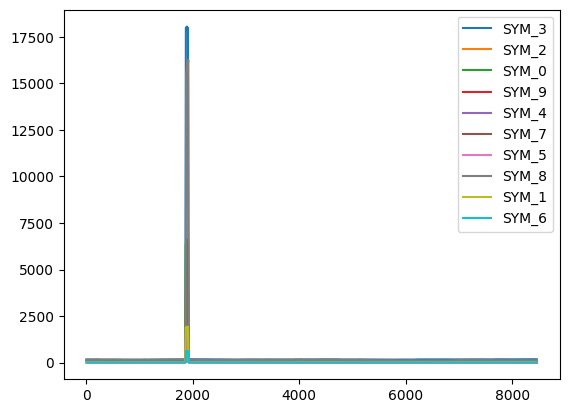

In [ ]:
#check each columns
# 1.Check the price column
from matplotlib import pyplot as plt
for stock in set(df.symbol):
    plt.plot(df.price[df.symbol == stock], label=stock)
    
plt.legend()

Text(0, 0.5, 'Number of rows')

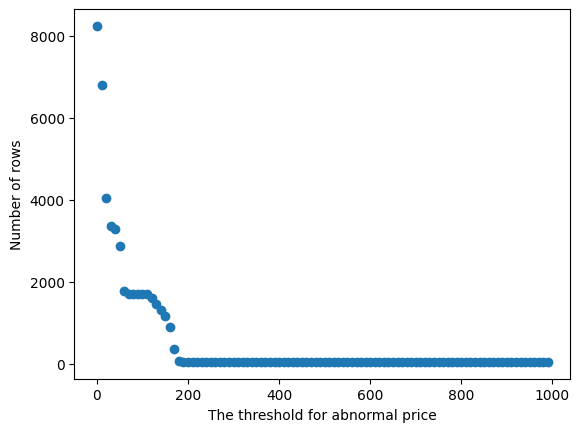

In [9]:
# Let's test the possible threshold for finding the abnormal prices:
thresholds = range(0, 1000, 10)
plt.scatter(x=thresholds, y=[df.price[df.price > v].count() for v in thresholds])
plt.xlabel("The threshold for abnormal price")
plt.ylabel("Number of rows")

In [ ]:
# A nearly constant number of rows that have abnormally larger price values
# check whether it is truly the same:
for p in range(100, 500, 25):
    print(f"Rows with price > {p}: ", df.price[df.price > p].count())

# I find out that there are 50 rows that have cosistently large price gaps. 
# It is highly possible that they are abnormal

Rows with price > 100:  1696
Rows with price > 125:  1518
Rows with price > 150:  1154
Rows with price > 175:  164
Rows with price > 200:  49
Rows with price > 225:  49
Rows with price > 250:  49
Rows with price > 275:  49
Rows with price > 300:  49
Rows with price > 325:  49
Rows with price > 350:  49
Rows with price > 375:  49
Rows with price > 400:  49
Rows with price > 425:  49
Rows with price > 450:  49
Rows with price > 475:  49


In [ ]:
print("Rows with abnormal prices:", df.price[df.price > 200].index)
# Check those abnormal values
print(df.price[df.price > 200])
# I find that they are simply rows from 1870-1919

Rows with abnormal prices: Index([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881,
       1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1915, 1916, 1917, 1918,
       1919],
      dtype='int64')
1870     6356.0
1871     1895.0
1872     3034.0
1873    17999.0
1874     1354.0
1875     1434.0
1876      612.0
1877     6483.0
1878    15493.0
1879     1093.0
1880     6358.0
1881     1899.0
1882     2986.0
1883    17980.0
1884     1357.0
1885     1486.0
1886      613.0
1887     6616.0
1888    15820.0
1889     1108.0
1890     6339.0
1891     1919.0
1892     2947.0
1893    18062.0
1894     1361.0
1895     1470.0
1896      616.0
1897     6583.0
1898    16120.0
1899     1117.0
1900     6305.0
1901     1920.0
1902     2927.0
1903    17870.0
1904     1374.0
1905     1479.0
1906      625.0
1907     6611.0
1908    15913.

In [23]:
df.head()

,symbol,date,price,vol,bin_fea,cat_fea1,cat_fea2,float_fea1,float_fea2,float_fea3,float_fea4,resp
0,SYM_0,2015-04-02,53.30,13.87,1.0,2.0,1.0,1.305993,0.229089,303764.190968,-0.142145,0.013593
1,SYM_1,2015-04-02,19.37,19.49,1.0,0.0,1.0,0.111880,0.400864,241821.209098,1.097191,-0.014367
2,SYM_2,2015-04-02,27.58,36.79,1.0,0.0,1.0,0.296334,0.501537,53724.862211,0.988944,-0.025442
3,SYM_3,2015-04-02,161.70,8.62,-1.0,0.0,1.0,-0.410091,0.143163,202984.910479,-0.108399,-0.005034
4,SYM_4,2015-04-02,13.65,10.72,-1.0,1.0,1.0,1.161879,0.555154,361774.898333,-0.293816,0.000626


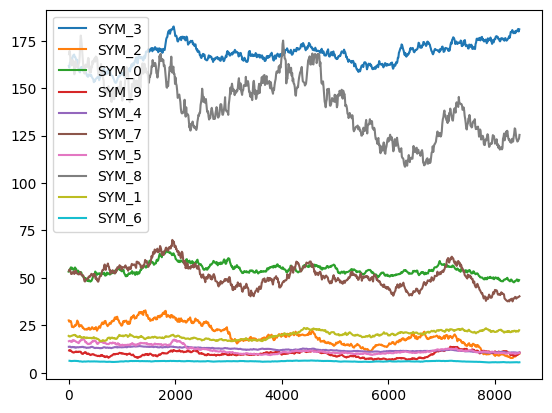

In [ ]:
# As we can see the normal stock prices preserves 2 decimals, 
# while the abnormal prices are all has zero decimal values. 
# So I should fix those values by multiplication of 0.01
corrected_df = df.copy()
corrected_df.loc[1870:1919, "price"] = df.loc[1870:1919, "price"]*0.01
# re-check the corrected values, it looks normal now.
for stock in set(corrected_df.symbol):
    plt.plot(corrected_df.price[corrected_df.symbol == stock], label=stock)
plt.legend()

1800    16.480000
1810    16.280000
1820    16.370000
1830    16.330000
1840    16.450000
1850    16.290000
1860    16.510000
1870     0.010281
1880     0.010406
1890     0.010544
1900     0.010494
1910     0.010437
1920    16.870000
Name: vol, dtype: float64

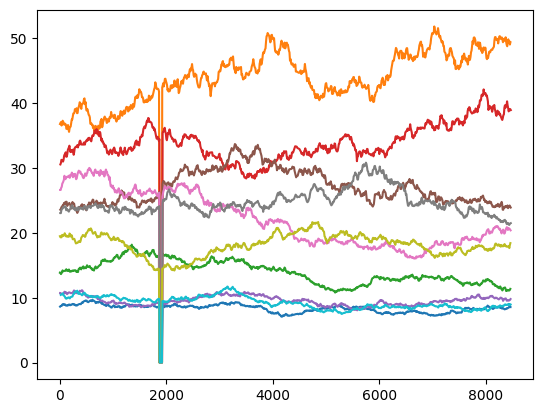

In [ ]:
# 2. Check the volitility of the stocks
for stock in set(df.symbol):
    plt.plot(df.vol[corrected_df.symbol == stock], label=stock)
# Can see abnormal downside spikes of values in some columns
# It looks like the abnormal values are also from the row 1870-1919
# Take SYM_0 for example, the spike is clearly
df[df.symbol =="SYM_0"].loc[1800:1925, "vol"]

In [ ]:
# To find the factor, compare the averages in the nearby window:
for stock in set(df.symbol):
    mean_abnormal = df[df.symbol ==stock].vol.loc[1870:1919].mean()
    mean_outside1 = df[df.symbol ==stock].vol.loc[1769:1869].mean()
    mean_outside2 = df[df.symbol ==stock].vol.loc[1920:2020].mean()
    
    print(stock, (mean_outside1+mean_outside2)/(2*mean_abnormal))
# So simply multiply vol by a factor of 1600 to roughly covert it back without lossing too much accuracy


SYM_3 1584.1357175607577
SYM_2 1617.5632836527097
SYM_0 1586.2318366991356
SYM_9 1611.9593087490373
SYM_4 1636.1678258918555
SYM_7 1581.9249349684133
SYM-5 nan
SYM_5 1635.957496315832
SYM_8 1599.0855649902046
SYM_1 1614.7613762486126
SYM_6 1578.6622212961033


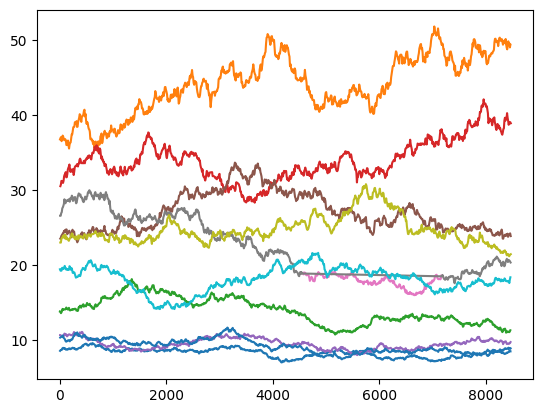

In [50]:
# correct vol by multiplicating the values by 1600
df.loc[1870:1919, "vol"] = df.loc[1870:1919, "vol"]*1600
for stock in set(df.symbol):
    plt.plot(df.vol[df.symbol == stock], label=stock)

### Part 1 Each column Analysis

1. The price data from 1870 to 1919 is incorrect, as it is 100 times larger than the normal value. Therefore, the data is corrected by multiplying it by 0.01.
2. Correct 'vol' by multiplicating the values by 1600 from 1870-1919.
3. Due to limited time, other features will be checked later.

## Part 2: make prediction


In this part, you are expected to implement the following `predict_fn` with the insight learned from training data (`train_data.csv`), here are the requirement for the `predict_fn`:

- It should take a dataframe in the same format of `df_sample_test` and returns a dataframe that has one additional column `pred`, the value of `pred` is a prediction for return from today's price to the next date's price for a given symbol, we will use squared-loss to measure how good the prediction is.
- All the values in `pred` column must be finite.
- For each row with date $d$, the prediction (the value of its "pred" column) must only depend on the information from date $d$ or dates prior to $d$.

Please keep all the intermediate steps (for example, how you trained the model) in this notebook.

Note that the actual dataframe we provide to `predict_fn` **will not contain any data issues** and will perfectly follow the specification of dataset in *Data explained* section. So you don't need to fix or handle data issues you found in Part 1 within the `predict_fn` function.

In [37]:
df=pd.read_csv("./train_data.csv")

In [38]:
def standardize_date(date_str):
    try:
        # First try YYYY-MM-DD format
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except:
        try:
            # Try DD/MM/YYYY format
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        except:
            try:
                # Try MM/DD/YYYY format
                return pd.to_datetime(date_str, format='%m/%d/%Y')
            except:
                # If all formats fail, print problematic date string for debugging
                print(f"Unable to parse date format: {date_str}")
                return pd.NaT



# Convert dates
df['date'] = df['date'].apply(standardize_date)

In [ ]:
#pre-process dataset
def clean_data(df):
    """
    Clean all issues found in the data
    
    Parameters:
    df: Original dataframe
    
    Returns:
    cleaned_df: Cleaned dataframe
    """
    # Create a copy to avoid modifying original data
    cleaned_df = df.copy()
    
    # 1. Clean bin_fea
    # Replace 0 values with closest valid value (1 in this case)
    cleaned_df['bin_fea'] = cleaned_df['bin_fea'].map(lambda x: 1 if x >= 0 else -1)
    
    # 2. Clean cat_fea1 
    def clean_cat_fea1(val):
        try:
            # If value is 'o', return 0 directly
            if val == 'o':
                return 0
                
            # Convert to float
            num_val = float(val)
            # Map out-of-range values to valid range
            if num_val > 2:
                return 2
            elif num_val < 0:
                return 0
            else:
                return int(num_val)  # Ensure integer return
        except (ValueError, TypeError):
            # Handle other invalid values, replace with 0
            return 0
    
    cleaned_df['cat_fea1'] = cleaned_df['cat_fea1'].apply(clean_cat_fea1)
    
    # 3. Clean cat_fea2
    # Ensure values are in 0-4 range
    cleaned_df['cat_fea2'] = cleaned_df['cat_fea2'].clip(0, 4)
    
    # 4. Clean float_fea2
    # Normalize values to [0,1] range
    def normalize_to_01(x):
        # Handle invalid values
        if pd.isna(x) or np.isinf(x):
            return 0.5  # Use middle value as default
        # Compress all values to [0,1] range
        return (x - cleaned_df['float_fea2'].min()) / (cleaned_df['float_fea2'].max() - cleaned_df['float_fea2'].min())
    
    cleaned_df['float_fea2'] = cleaned_df['float_fea2'].apply(normalize_to_01)
    
    # 5. Handle infinities and NaN in all numeric columns
    numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        # Replace infinite values
        cleaned_df[col] = cleaned_df[col].replace([np.inf, -np.inf], np.nan)
        # Fill NaN with median
        cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())
    
    return cleaned_df

# Usage example
# cleaned_df = clean_data(df)

# Verification function
def verify_cleaning(df_original, df_cleaned):
    """
    Verify that cleaned data meets requirements
    """
    print("Data cleaning verification results:")
    
    # Verify bin_fea
    print("\nbin_fea unique values:", df_cleaned['bin_fea'].unique())
    print("bin_fea contains only -1 and 1:", set(df_cleaned['bin_fea'].unique()) <= {-1, 1})
    
    # Verify cat_fea1
    print("\ncat_fea1 unique values:", df_cleaned['cat_fea1'].unique())
    print("cat_fea1 is within range:", set(df_cleaned['cat_fea1'].unique()) <= {0, 1, 2})
    
    # Verify cat_fea2
    print("\ncat_fea2 unique values:", df_cleaned['cat_fea2'].unique())
    print("cat_fea2 is within range:", set(df_cleaned['cat_fea2'].unique()) <= {0, 1, 2, 3, 4})
    
    # Verify float_fea2
    print("\nfloat_fea2 range:")
    print("Minimum value:", df_cleaned['float_fea2'].min())
    print("Maximum value:", df_cleaned['float_fea2'].max())
    
    # Check for NaN or infinite values
    print("\nNaN or infinite values exist:", 
          df_cleaned.isnull().any().any() or 
          np.isinf(df_cleaned.select_dtypes(include=[np.number])).any().any())

cleaned_df = clean_data(df)
verify_cleaning(df, cleaned_df)

Data cleaning verification results:

bin_fea unique values: [ 1 -1]
bin_fea contains only -1 and 1: True

cat_fea1 unique values: [2 0 1]
cat_fea1 is within range: True

cat_fea2 unique values: [1. 2. 3. 0. 4.]
cat_fea2 is within range: True

float_fea2 range:
Minimum value: 0.0
Maximum value: 1.0

NaN or infinite values exist: False


In [40]:
cleaned_df


,symbol,date,price,vol,bin_fea,cat_fea1,cat_fea2,float_fea1,float_fea2,float_fea3,float_fea4,resp
0,SYM_0,2015-04-02,53.30,13.87,1,2,1.0,1.305993,0.002616,303764.190968,-0.142145,0.013593
1,SYM_1,2015-04-02,19.37,19.49,1,0,1.0,0.111880,0.004578,241821.209098,1.097191,-0.014367
2,SYM_2,2015-04-02,27.58,36.79,1,0,1.0,0.296334,0.005728,53724.862211,0.988944,-0.025442
3,SYM_3,2015-04-02,161.70,8.62,-1,0,1.0,-0.410091,0.001635,202984.910479,-0.108399,-0.005034
4,SYM_4,2015-04-02,13.65,10.72,-1,1,1.0,1.161879,0.006340,361774.898333,-0.293816,0.000626
...,...,...,...,...,...,...,...,...,...,...,...,...
8465,SYM_5,2018-06-29,10.43,20.39,-1,2,0.0,-1.659064,0.003957,774616.709739,-1.469094,-0.020758
8466,SYM_6,2018-06-29,5.48,8.95,1,0,4.0,-1.711967,0.004979,886319.453734,2.121276,0.003000
8467,SYM_7,2018-06-29,40.28,23.91,1,1,1.0,-1.275087,0.006682,167704.960907,-0.427564,0.010854
8468,SYM_8,2018-06-29,125.39,21.50,-1,0,1.0,-1.848229,0.007012,440334.179106,-0.428545,0.021145


In [ ]:
#prepare dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
def prepare_data(df):
    """
    Prepare data for model training, mainly performing feature standardization and handling infinite values
    """
    # Create copy to avoid modifying original data
    df = df.copy()
    
    # Define feature columns
    feature_columns = ['price', 'vol', 'bin_fea', 'cat_fea1', 'cat_fea2', 
                      'float_fea1', 'float_fea2', 'float_fea3', 'float_fea4']
    
    # Distinguish between categorical and numerical features
    cat_features = ['bin_fea', 'cat_fea1', 'cat_fea2']
    num_features = ['price', 'vol', 'float_fea1', 'float_fea2', 'float_fea3', 'float_fea4']
            
    # Special handling for float_fea3
    def transform_float_fea3(x):
        if np.isfinite(x) and x != 0:
            # Use log transform to handle extreme values
            return np.sign(x) * np.log1p(np.abs(x))
        return 0
    
    df['float_fea3'] = df['float_fea3'].apply(transform_float_fea3)
    

    
    # Ensure cat_fea1 is numeric type
    df['cat_fea1'] = pd.to_numeric(df['cat_fea1'], errors='coerce')
    
    # Standardize numerical features
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    return df, feature_columns, scaler

processed_df, feature_columns, scaler = prepare_data(cleaned_df)
processed_df


,symbol,date,price,vol,bin_fea,cat_fea1,cat_fea2,float_fea1,float_fea2,float_fea3,float_fea4,resp
0,SYM_0,2015-04-02,-0.045895,-0.622327,1,2,1.0,1.319066,-0.150172,0.064544,-0.123035,0.013593
1,SYM_1,2015-04-02,-0.099597,-0.132290,1,0,1.0,0.122435,-0.098561,0.051555,1.114323,-0.014367
2,SYM_2,2015-04-02,-0.086603,1.376190,1,0,1.0,0.307277,-0.068313,-0.034122,1.006249,-0.025442
3,SYM_3,2015-04-02,0.125676,-1.080103,-1,0,1.0,-0.400637,-0.175989,0.041584,-0.089342,-0.005034
4,SYM_4,2015-04-02,-0.108651,-0.896993,-1,1,1.0,1.174648,-0.052204,0.074498,-0.274464,0.000626
...,...,...,...,...,...,...,...,...,...,...,...,...
8465,SYM_5,2018-06-29,-0.113747,-0.053814,-1,2,0.0,-1.652244,-0.114904,0.117860,-1.447866,-0.020758
8466,SYM_6,2018-06-29,-0.121582,-1.051328,1,0,4.0,-1.705258,-0.088013,0.125532,2.136774,0.003000
8467,SYM_7,2018-06-29,-0.066502,0.253114,1,1,1.0,-1.267457,-0.043225,0.030710,-0.407998,0.010854
8468,SYM_8,2018-06-29,0.068206,0.042973,-1,0,1.0,-1.841808,-0.034523,0.085690,-0.408977,0.021145


In [ ]:
#Dataset class
class StockDataset(Dataset):
    def __init__(self, df, feature_columns, sequence_length=5):  
        self.sequence_length = sequence_length
        
        # Ensure all features are numeric type
        df_features = df[feature_columns].astype(float)
        
        # Sort by stock and date
        df = df.sort_values(['symbol', 'date'])
        
        # Process data grouped by stock
        grouped = df.groupby('symbol')
        self.sequences = []
        self.targets = []
        
        print(f"Data size before processing: {len(df)}")
        
        for symbol, group in grouped:
            features = group[feature_columns].values
            targets = group['resp'].values
            
            # Create sequences
            for i in range(len(features) - sequence_length + 1):
                seq = features[i:(i + sequence_length)]
                # Use resp value of last day in sequence as target
                target = targets[i + sequence_length - 1]
                
                # Check if sequence contains invalid values
                if np.isfinite(seq).all() and np.isfinite(target):
                    self.sequences.append(seq)
                    self.targets.append(target)
        
        print(f"Number of sequences after processing: {len(self.sequences)}")
        
        if len(self.sequences) == 0:
            raise ValueError("No valid sequence data generated, please check input data")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor([self.targets[idx]])



# Create dataset and check
try:
    dataset = StockDataset(processed_df, feature_columns)
    print(f"\nShape of first sequence: {dataset.sequences[0].shape}")
    print(f"First target value: {dataset.targets[0]}")
    
    # Create DataLoader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Check first batch
    for batch_features, batch_targets in train_loader:
        print(f"\nShape of first batch: {batch_features.shape}")
        print(f"Shape of first batch targets: {batch_targets.shape}")
        break
        
except Exception as e:
    print(f"Error: {str(e)}")
    
    # Debug information
    print("\nDebug information:")
    print(f"Feature columns: {feature_columns}")
    print(f"Shape of processed data: {processed_df.shape}")
    print("\nData types of feature columns:")
    print(processed_df[feature_columns].dtypes)
    print("\nMissing value statistics for feature columns:")
    print(processed_df[feature_columns].isnull().sum())


Data size before processing: 8470
Number of sequences after processing: 8426

Shape of first sequence: (5, 9)
First target value: 0.0257270119922866

Shape of first batch: torch.Size([32, 5, 9])
Shape of first batch targets: torch.Size([32, 1])


In [ ]:
# Define LSTM and Transformer model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions


class TransformerPredictor(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=8, num_layers=2, dropout=0.1):
        super(TransformerPredictor, self).__init__()
        
        self.input_proj = nn.Linear(input_size, d_model)
        

        self.pos_encoder = nn.ModuleList([
            nn.Linear(d_model, d_model) for _ in range(5)
        ])
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.output = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):

        x = self.input_proj(x)
        
        batch_size, seq_len, _ = x.shape
        encoded = []
        for i in range(seq_len):

            pos_encoded = self.pos_encoder[i](x[:, i]) 
            encoded.append(pos_encoded)
        

        x = torch.stack(encoded, dim=1)
            

        out = self.transformer_encoder(x)
        

        out = self.output(out[:, -1, :])
        
        return out


In [56]:
def split_data_by_date(df, train_ratio=0.8):
    """
    Split data into training and validation sets by date order
    
    Parameters:
    df: DataFrame, dataset containing 'date' column
    train_ratio: float, ratio of training set
    
    Returns:
    train_df, valid_df: DataFrames for training and validation sets
    """
    # Sort by date
    df = df.sort_values('date')
    
    # Calculate split point
    train_split_idx = int(len(df) * train_ratio)
    train_split_date = df.iloc[train_split_idx]['date']
    
    # Split DataFrame directly
    train_df = df[df['date'] < train_split_date].copy()
    valid_df = df[df['date'] >= train_split_date].copy()
    
    print(f"Training set date range: {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"Validation set date range: {valid_df['date'].min()} to {valid_df['date'].max()}")
    print(f"Number of training samples: {len(train_df)}")
    print(f"Number of validation samples: {len(valid_df)}")
    
    return train_df, valid_df

# Split dataset
train_df, valid_df = split_data_by_date(processed_df, train_ratio=0.8)

# Create datasets
train_dataset = StockDataset(train_df, feature_columns)
valid_dataset = StockDataset(valid_df, feature_columns)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Training set date range: 2015-04-02 00:00:00 to 2017-11-03 00:00:00
Validation set date range: 2017-11-06 00:00:00 to 2018-06-29 00:00:00
Number of training samples: 6770
Number of validation samples: 1700
Data size before processing: 6770
Number of sequences after processing: 6726
Data size before processing: 1700
Number of sequences after processing: 1656


In [57]:
def train_model(train_loader, valid_loader, model_type='lstm', **kwargs):
    # Set device
    device = 'cpu'# kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Model parameters
    input_size = len(feature_columns)
    num_epochs = kwargs.get('num_epochs', 50)
    patience = kwargs.get('patience', 7)
    
    # Initialize model
    if model_type.lower() == 'lstm':
        model = LSTMPredictor(
            input_size=input_size,
            hidden_size=kwargs.get('hidden_size', 64),
            num_layers=kwargs.get('num_layers', 2)
        )
    elif model_type.lower() == 'transformer':
        model = TransformerPredictor(
            input_size=input_size,
            d_model=kwargs.get('d_model', 64),
            nhead=kwargs.get('nhead', 8),
            num_layers=kwargs.get('num_layers', 2),
            dropout=kwargs.get('dropout', 0.1)
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 0.001))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    # Training records
    history = {
        'train_loss': [],
        'valid_loss': [],
        'learning_rates': []
    }
    
    best_valid_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step
            optimizer.step()
            
            train_losses.append(loss.item())
            
            # Print progress
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        avg_train_loss = np.mean(train_losses)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        valid_losses = []
        
        with torch.no_grad():
            for sequences, targets in valid_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                valid_losses.append(loss.item())
        
        avg_valid_loss = np.mean(valid_losses)
        history['valid_loss'].append(avg_valid_loss)
        
        # Record current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        # Learning rate adjustment
        scheduler.step(avg_valid_loss)
        
        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Valid Loss: {avg_valid_loss:.4f}, '
              f'LR: {current_lr:.6f}')
        
        # Model saving and early stopping
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
            print(f'New best model saved! Valid Loss: {best_valid_loss:.4f}')
        else:
            patience_counter += 1
            print(f'EarlyStopping counter: {patience_counter} out of {patience}')
        
        if patience_counter >= patience:
            print('Early stopping triggered')
            break
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, history


Using device: cpu


/opt/anaconda3/envs/tabllm/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/10], Step [100/211], Loss: 0.0001
Epoch [1/10], Step [200/211], Loss: 0.0002
Epoch [1/10] - Train Loss: 0.0004, Valid Loss: 0.0003, LR: 0.000050
New best model saved! Valid Loss: 0.0003
Epoch [2/10], Step [100/211], Loss: 0.0003
Epoch [2/10], Step [200/211], Loss: 0.0003
Epoch [2/10] - Train Loss: 0.0003, Valid Loss: 0.0003, LR: 0.000050
New best model saved! Valid Loss: 0.0003
Epoch [3/10], Step [100/211], Loss: 0.0002
Epoch [3/10], Step [200/211], Loss: 0.0001
Epoch [3/10] - Train Loss: 0.0003, Valid Loss: 0.0003, LR: 0.000050
New best model saved! Valid Loss: 0.0003
Epoch [4/10], Step [100/211], Loss: 0.0001
Epoch [4/10], Step [200/211], Loss: 0.0003
Epoch [4/10] - Train Loss: 0.0002, Valid Loss: 0.0003, LR: 0.000050
New best model saved! Valid Loss: 0.0003
Epoch [5/10], Step [100/211], Loss: 0.0003
Epoch [5/10], Step [200/211], Loss: 0.0002
Epoch [5/10] - Train Loss: 0.0002, Valid Loss: 0.0003, LR: 0.000050
New best model saved! Valid Loss: 0.0003
Epoch [6/10], Step [100/2

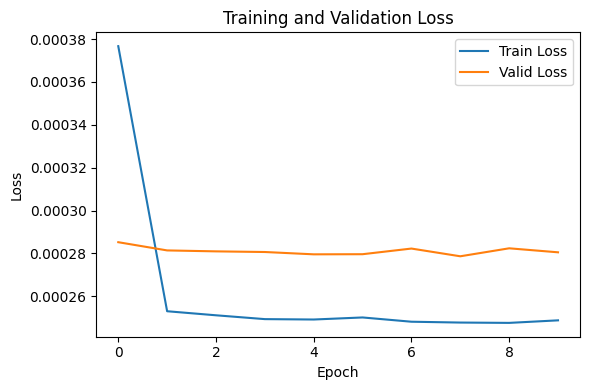

Final training loss: 0.0002
Final validation loss: 0.0003
Best validation loss: 0.0003


In [ ]:
#1. LSTM model
import matplotlib.pyplot as plt
model_params = {
    'model_type': 'lstm',
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.1,
    'lr': 0.00005,
    'num_epochs': 10,
    'patience': 7,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Train model
try:
    model, history = train_model(train_loader, valid_loader, **model_params)
    
    # Plot training history
    plt.figure(figsize=(6, 4))

    # Loss curves
    plt.subplot(1, 1, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # # Learning rate curve
    # plt.subplot(1, 2, 2)
    # plt.plot(history['learning_rates'])
    # plt.title('Learning Rate')
    # plt.xlabel('Epoch')
    # plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

    # Print final training and validation losses
    print(f"Final training loss: {history['train_loss'][-1]:.4f}")
    print(f"Final validation loss: {history['valid_loss'][-1]:.4f}")
    print(f"Best validation loss: {min(history['valid_loss']):.4f}")

except Exception as e:
    print("Training error occurred:")
    print(str(e))
    # Print detailed error information
    import traceback
    traceback.print_exc()


Using device: cpu
Epoch [1/20], Step [100/211], Loss: 0.0036
Epoch [1/20], Step [200/211], Loss: 0.0011
Epoch [1/20] - Train Loss: 0.0072, Valid Loss: 0.0008, LR: 0.000100
New best model saved! Valid Loss: 0.0008
Epoch [2/20], Step [100/211], Loss: 0.0012
Epoch [2/20], Step [200/211], Loss: 0.0012
Epoch [2/20] - Train Loss: 0.0010, Valid Loss: 0.0005, LR: 0.000100
New best model saved! Valid Loss: 0.0005
Epoch [3/20], Step [100/211], Loss: 0.0014
Epoch [3/20], Step [200/211], Loss: 0.0006
Epoch [3/20] - Train Loss: 0.0007, Valid Loss: 0.0004, LR: 0.000100
New best model saved! Valid Loss: 0.0004
Epoch [4/20], Step [100/211], Loss: 0.0008
Epoch [4/20], Step [200/211], Loss: 0.0006
Epoch [4/20] - Train Loss: 0.0005, Valid Loss: 0.0003, LR: 0.000100
New best model saved! Valid Loss: 0.0003
Epoch [5/20], Step [100/211], Loss: 0.0005
Epoch [5/20], Step [200/211], Loss: 0.0003
Epoch [5/20] - Train Loss: 0.0004, Valid Loss: 0.0003, LR: 0.000100
New best model saved! Valid Loss: 0.0003
Epoch [

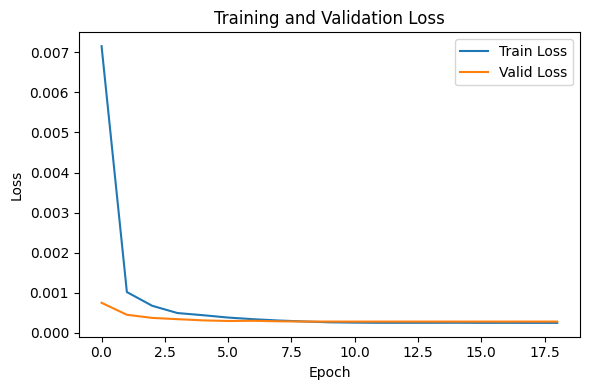

Final training loss: 0.0003
Final validation loss: 0.0003
Best validation loss: 0.0003


In [59]:
#2. transformer model
model_params = {
    'model_type': 'transformer',
    'd_model': 64,
    'nhead': 8,
    'num_layers': 2,
    'dropout': 0.1,
    'lr': 0.0001,
    'num_epochs': 20,
    'patience': 7
}

# Train model
try:
    model, history = train_model(train_loader, valid_loader, **model_params)
    
    # Plot training history
    plt.figure(figsize=(6, 4))

    # Loss curves
    plt.subplot(1, 1, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # # Learning rate curve
    # plt.subplot(1, 2, 2)
    # plt.plot(history['learning_rates'])
    # plt.title('Learning Rate')
    # plt.xlabel('Epoch')
    # plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

    # Print final training and validation losses
    print(f"Final training loss: {history['train_loss'][-1]:.4f}")
    print(f"Final validation loss: {history['valid_loss'][-1]:.4f}")
    print(f"Best validation loss: {min(history['valid_loss']):.4f}")

except Exception as e:
    print("Training error occurred:")
    print(str(e))
    # Print detailed error information
    import traceback
    traceback.print_exc()

In [60]:
def predict_fn(df_test):
    # Please replace the following line with your own implementation of this function
    df_test['pred'] = df_test.eval('float_fea1 * 10 + float_fea2').fillna(0)
    return df_test

In [61]:
def predict_fn(df_test):
    """
    Make predictions on test data using the trained model
    """
    # Create deep copy to ensure original data is not modified
    df_pred = df_test.copy(deep=True)
    df_temp = df_pred.copy()
    
    feature_columns = ['price', 'vol', 'bin_fea', 'cat_fea1', 'cat_fea2', 
                      'float_fea1', 'float_fea2', 'float_fea3', 'float_fea4']
    
    # Data preprocessing
    df_temp['float_fea3'] = df_temp['float_fea3'].apply(
        lambda x: np.sign(x) * np.log1p(np.abs(x)) if np.isfinite(x) and x != 0 else 0
    )
    
    df_temp['cat_fea1'] = pd.to_numeric(df_temp['cat_fea1'], errors='coerce')
    
    num_features = ['price', 'vol', 'float_fea1', 'float_fea2', 'float_fea3', 'float_fea4']
    df_temp[num_features] = scaler.transform(df_temp[num_features])
    
    sequence_length = 5
    all_predictions = []  # Store all predictions
    
    # Process by stock groups
    for symbol, group in df_temp.groupby('symbol'):
        group = group.sort_values('date')
        features = group[feature_columns].values
        group_predictions = []  # Store predictions for current stock
        
        # If data length is less than sequence_length, use 0 as prediction
        if len(features) < sequence_length:
            group_predictions = [0.0] * len(features)
        else:
            # Create sequences for each time point
            for i in range(len(features) - sequence_length + 1):
                seq = features[i:(i + sequence_length)]
                if np.isfinite(seq).all():
                    seq_tensor = torch.FloatTensor(seq).unsqueeze(0)
                    with torch.no_grad():
                        pred = model(seq_tensor)
                    group_predictions.append(pred.item())
                else:
                    group_predictions.append(0.0)
            
            # Handle first sequence_length-1 points
            default_value = group_predictions[0] if group_predictions else 0.0
            prefix = [default_value] * (sequence_length - 1)
            group_predictions = prefix + group_predictions
        
        all_predictions.extend(group_predictions)
    
    # Ensure prediction length matches original data
    if len(all_predictions) != len(df_temp):
        print(f"Warning: predictions length ({len(all_predictions)}) != data length ({len(df_temp)})")
        # Fill with 0 if lengths don't match
        all_predictions = all_predictions[:len(df_temp)]
        if len(all_predictions) < len(df_temp):
            all_predictions.extend([0.0] * (len(df_temp) - len(all_predictions)))
    
    # Add predictions and handle outliers
    df_pred['pred'] = all_predictions
    
    # Ensure no null values
    df_pred['pred'] = df_pred['pred'].fillna(0)
    
    # Ensure no infinite values
    df_pred['pred'] = df_pred['pred'].replace([np.inf, -np.inf], 0)
    
    return df_pred

In [63]:
# Process processed_df using predict_fn
df_pred = predict_fn(processed_df.copy())

# Calculate MSE loss
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_pred['resp'], df_pred['pred'])

# Calculate MAE loss
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df_pred['resp'], df_pred['pred'])

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Mean Squared Error (MSE): 0.000314
Mean Absolute Error (MAE): 0.012087


### Run the following cell to validate your predict function, make sure it doesn't raise any exception

In [62]:
df_sample_test = pd.read_csv('./sample_data.csv')
df_test = predict_fn(df_sample_test.copy(deep=True))
assert df_test[df_sample_test.columns].equals(df_sample_test)
assert [c for c in df_test if c not in df_sample_test] == ['pred']
assert not df_test['pred'].isnull().any()

### Analysis: I have built LSTM and Transformer model to do prediction, Transformer performs better than LSTM, and final mse is 0.000314.